# Build models

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as metrics

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Separate training and test datasets

In [1]:
# Load dataset
dataset_ = pd.read_csv('../save/data_bc_fisrt_addattr_scraped_alldates.csv')
dataset_.shape

NameError: name 'pd' is not defined

88

In [5]:
#dataset['FriSat'] = dataset.apply(lambda x: int(x['Fri']==1 or x['Sat']==1) ,axis=1)

In [6]:
dataset = dataset_.copy()

In [7]:
dataset.columns.values

array(['id', 'host_since', 'latitude', 'longitude', 'accommodates',
       'bathrooms', 'bedrooms', 'beds', 'cleaning_fee', 'guests_included',
       'extra_people', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'first_review',
       'last_review', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'review_scores_rating', 'no_reviews', 'Adams',
       'Alki', 'Arbor Heights', 'Atlantic', 'Belltown', 'Bitter Lake',
       'Briarcliff', 'Brighton', 'Broadview', 'Broadway', 'Bryant',
       'Cedar Park', 'Central Business District', 'Columbia City',
       'Crown Hill', 'Dunlap', 'East Queen Anne', 'Eastlake',
       'Fairmount Park', 'Fauntleroy', 'First Hill', 'Fremont',
       'Gatewood', 'Genesee', 'Georgetown', 'Green Lake', 'Greenwood',
       'Haller Lake', 'Harrison/Denny-Blaine', 'High Point',
       'Highland Park', 'Holly Park', 'Industrial District', 'Interbay',
       'International District', 'Laurelhurst', 'Lawton Park', '

In [47]:
'''
dataset = dataset.drop(columns=['FriSat','week', 'days_from_scraped','date','Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2018', '2019',
       'ChristmasHolidays', 'NewYear', 'MartinLK', 'President',
       'Memorial', 'Independence', 'Labor', 'Columbus', 'Veterans',
       'Thanksgiving'])
'''

In [37]:
#dataset.drop(columns='availability_90',inplace=True)

In [103]:
# Further delete unusable listings 
#dataset = dataset[pd.isnull(dataset['host_since']).values==False]
#dataset = dataset[pd.isnull(dataset['bedrooms']).values==False]
#dataset = dataset[dataset['price']!=0]
#dataset.shape

(1111403, 174)

In [93]:
'''
def myreview(x):
    values = np.array([2,3,4,5,6,7,8,9,10])
    v = values[x==1]
    if len(v)==1:
        return v[0]
    else:
        return 0
dataset['review_accuracy'] = dataset.apply(lambda x: myreview(x[['2.0', '3.0', '4.0', '5.0', '6.0',
       '7.0', '8.0', '9.0', '10.0']]==1) ,axis=1)
'''

In [94]:
#dataset.drop(columns =['2.0', '3.0', '4.0', '5.0', '6.0','7.0', '8.0', '9.0', '10.0'],inplace=True )

In [102]:
#dataset.drop(columns=['availability_90'],inplace=True)

In [113]:
#dataset.drop(columns=['availability_60'],inplace=True)

In [120]:
#dataset.drop(columns=['availability_30'],inplace=True)

In [8]:
# Separate training and test data
ids = dataset.id.unique()
np.random.shuffle(ids)
ids_train = ids[:int(0.8 * len(ids))]
ids_test = ids[int(0.8 * len(ids)):]
dataset_train = dataset[dataset['id'].isin(ids_train)].drop(columns='id')
dataset_test = dataset[dataset['id'].isin(ids_test)].drop(columns='id')

In [ ]:
# Get features and target
x_train = dataset_train.drop(columns = 'price').values
y_train = np.log(dataset_train['price'].values)

x_test = dataset_test.drop(columns = 'price').values
y_test = np.log(dataset_test['price'].values)

## Train models

### - Random Forest

In [112]:
# Without cross-validation
rf = RandomForestRegressor(n_estimators = 20)
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

0.6827007325236853

In [113]:
# Cross-validation
rf = RandomForestRegressor(n_estimators = 20, max_features = 0.8)

param_grid = {'min_samples_leaf': [2, 5, 8, 12]}

cv = GridSearchCV(rf, param_grid, cv = 5)
cv.fit(x_train, y_train)
cv.best_estimator_

KeyboardInterrupt: 

In [27]:
# Training 
rf_optm = RandomForestRegressor()
rf_optm.fit(x_train, y_train)

# Test
rf_optm.score(x_test, y_test)
y_predict = rf_optm.predict(x_test)
error = metrics.median_absolute_error(y_test, y_predict)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [29]:
metrics.median_absolute_error(y_test, np.exp(prediction))

27.294618271352974

### - XGBoost

In [ ]:
# dtrain = xgb.DMatrix('./data/agaricus.txt.train')
# dtest = xgb.DMatrix('./data/agaricus.txt.test')
dtrain = xgb.DMatrix(x_train[:], label=y_train)
dtest = xgb.DMatrix(x_test[:], label=y_test)
# specify parameters via map
param = {'max_depth':15, 'eta':0.3, 'lambda':1, 
         'silent':1, 'objective':'reg:linear', 
         #'tree_method':'gpu_hist', 
         'eval_metric':'rmse'}
num_round = 20
bst = xgb.train(param, dtrain, num_round)
# make prediction
preds = bst.predict(dtest)

In [ ]:
metrics.median_absolute_error(np.exp(y_test), np.exp(preds))

In [ ]:
ax = xgb.plot_importance(bst, max_num_features = 20)

In [ ]:
impfeatures = [int(str(x).split('\'')[1][1:]) for x in ax.get_yticklabels()]
impfeatures.reverse()
cols = list(dataset_train.columns.values)
cols.remove('price')
for i in impfeatures: print(i,cols[i])

### - GBDT

In [68]:
dataset_train.columns.values

array(['host_since', 'latitude', 'longitude', 'accommodates', 'bathrooms',
       'bedrooms', 'beds', 'cleaning_fee', 'guests_included',
       'extra_people', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'first_review',
       'last_review', 'minimum_nights', 'maximum_nights',
       'number_of_reviews', 'Adams', 'Alki', 'Arbor Heights', 'Atlantic',
       'Belltown', 'Bitter Lake', 'Briarcliff', 'Brighton', 'Broadview',
       'Broadway', 'Bryant', 'Cedar Park', 'Central Business District',
       'Columbia City', 'Crown Hill', 'Dunlap', 'East Queen Anne',
       'Eastlake', 'Fairmount Park', 'Fauntleroy', 'First Hill',
       'Fremont', 'Gatewood', 'Genesee', 'Georgetown', 'Green Lake',
       'Greenwood', 'Haller Lake', 'Harrison/Denny-Blaine', 'High Point',
       'Highland Park', 'Holly Park', 'Industrial District', 'Interbay',
       'International District', 'Laurelhurst', 'Lawton Park', 'Leschi',
       'Lower Queen Anne', 'Loyal Heights'

In [21]:
max(dataset_train[dataset_train.columns.values[7]])

13.736984342210164

(array([819176.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,      0.,      0.,      0.,      0.,      0.,
      

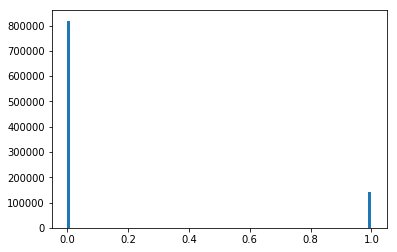

In [44]:
plt.hist(dataset_train[dataset_train.columns.values[197]],  bins=100)